# Projekt - Symulacja pożaru lasu
Opis: Symulacja pożaru lasu, uwzględniająca parametry takie jak kierunek wiatru, gęstość roślinności czy rzeźba terenu. Symulacja przeprowadzona za pomocą automatu komórkowego. 

Cel: Analiza tempa rozprzestrzeniania się ognia oraz skali zniszczeń w zależności od parametrów.

Istota problemu:
- Wpływ pożaru na cały ekosystem (życie ludzkie, dziką przyrodę, roślinność, infrastrukturę)
- Potrzeba zapobiegania, kontroli i zarządzania pożarami

Automat komórkowy:
- podział powierzchni na komórki macierzy wymiaru m*n
- matematyczny model, ewolujący poprzez dyskretne zdarzenia w systemie dynamicznym
- każda komórka posiada swój stan początkowy, a jej stan po chwili t jest zależny od stanu początkowego i stanu jej sąsiadów

Cechy automatu komórkowego:
- Infrastruktura - wmiary macierzy i topologia
- Stany komórek
- Stany i liczba sąsiadów
- Reguły zmiany stanu


Model symulacji (model Alexandridisa):
- model sąsiedztwa Moore'a (każda komórka ma 8 sąsiadów)
- profil roślinności - komórka, na której znajduje się roślinność spłonie z wyzwoleniem ciepła zależnym od rodzaju paliwa
- gęstość występującej roślinności
- wilgotność 
- prędkość i kierunek wiatru
- rzeźba terenu

Stany komórek
- 0 - brak paliwa
- 1 - teren zielony, możliwość zapłonu
- 2 - palący się teren
- 3 - spalony teren, brak paliwa

Reguły zmiany stanu:
- 0 $\rightarrow$ 0
- 2 $\rightarrow$ 3
- 3 $\rightarrow$ 3
- (i, j, t) = 2 $\rightarrow$ (i ± 1,j ± 1,t + 1) = 2 z pewnym prawdopodobieństwem

$$P_{burn} = P_0(1 + P_{veg})(1 + P_{den}) * P_w * P_{ele}$$

$P_0$ - stała empiryczna =0,58<br>
$P_{veg}$ - rodzaj roślinnośći<br>
$P_{den}$ - gęstość roślinności (niska = -0.4, średnia = 0, wysoka = 0.3)<br>
$P_w$ - prędkość wiatru: $$P_w = exp(c_1V) exp(Vc_2(cos\Theta - 1))$$
$\Theta$ - kąt pomiędzy kierunkiem propoagowania pożaru a kierunkiem wiatru <br>
$c_1 = 0.045$<br>
$c_2 = 0.131$<br>
$P_{ele}$ - rzeźba terenu: $$P_{ele} = exp(a\Theta)$$
$a = 0.078$<br>
$\Theta = arctan(\frac{E_1 - E_2}l)$ - rozprzestrzenianie wzdłużne<br>
$\Theta = arctan(\frac{E_1 - E_2}{l\surd2})$ - rozprzestrzenianie diagonalne<br>
$E_1$ - wysokość komórki sąsiedniej<br>
$E_2$ - wysokość komórki centralnej <br>
$l$ - odległość pomiędzy komórkami

In [1]:
using Statistics

In [2]:
using Plots
colours = palette([:lightblue, :chartreuse4, :tomato, :grey24]);


(process:19200): GLib-GIO-WARNING **: 22:12:16.496: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.2.12.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 46 extensions but has no verbs


In [4]:
function next_state(_forest, speed, angle, elevation_matrix, vegetation_density)
    n, m = size(_forest)
    new_forest = copy(_forest)
    for i in 1:n
        for j in 1:m
            if _forest[i, j] == 2
                for k in i-1:i+1
                    for l in j-1:j+1
                        p = calculate_probability(_forest, (i, j), (k, l),
                            speed, angle, elevation_matrix, vegetation_density)
                        if rand() <= p
                            new_forest[k, l] = 2
                        end
                    end
                end
                new_forest[i, j] = 3
            end                        
        end
    end
    return new_forest
end

next_state (generic function with 1 method)

In [3]:
function calculate_probability(_forest, central_cell, neighbouring_cell, speed, angle, elevation_matrix, vegetation_density)
    i, j = central_cell
    k, l = neighbouring_cell
    if _forest[k, l] == 0 || _forest[k, l] == 2 || _forest[k, l] == 3
        return 0 # dla wody, płonącego i spalonego lasu
    end
    p_wind = calculate_p_wind((i, j), (k, l), speed, angle)
    p_ele = calculate_p_ele((i, j), (k, l), elevation_matrix)
    p_den = vegetation_density[k, l]
    probability = 0.58 * p_wind * p_ele *(1 + p_den)
    return probability
end

calculate_probability (generic function with 1 method)

In [5]:
function burn_forest(forest, wind_speed, wind_angle, elevation_matrix, vegetation_density)
    changes_made = true
    steps = 0
    burnt_cells_list=[]
    while changes_made
        burnt_cells=count(i -> (i == 3), forest)
        push!(burnt_cells_list, burnt_cells)
        changed_forest = next_state(forest, wind_speed, wind_angle, elevation_matrix, vegetation_density)
        if forest == changed_forest
            changes_made = false
        else
            forest = changed_forest
            steps = steps + 1
        end
    end
    return forest, steps, burnt_cells_list
end

burn_forest (generic function with 1 method)

In [6]:
function make_gif(_forest, speed, angle, elevation_matrix, vegetation_density)
    s = size(_forest)[1]
    @animate for k in 1:35
        to_display = _forest[2 : s - 1, 2 : s - 1] # usuwanie wody wokół lasu
        heatmap(to_display,
            seriescolor = colours,
            clim = (0, 3),
            framestyle = :none,
            yflip = true)
        _forest = next_state(_forest, speed, angle, elevation_matrix, vegetation_density)
    end
end

make_gif (generic function with 1 method)

### 1 - Animacja płonącego lasu
- średnia gęstość roślinności
- teren płaski 
- prędkośc wiatru - 0

In [7]:
forest_size = 20
vegetation_density = zeros(forest_size + 2, forest_size + 2)
elevation_matrix = zeros(forest_size + 2, forest_size + 2)
forest = [i == 1 || j == 1 || i == forest_size + 2 || j == forest_size + 2 ?
          0 : 1 for i in 1 : forest_size + 2, j in 1 : forest_size + 2]
forest[div(forest_size, 2) + 1, div(forest_size, 2) + 1] = 2;

┌ Info: Saved animation to 
│   fn = C:\Users\mlubn\pakiety projekt\wildfire.gif
└ @ Plots C:\Users\mlubn\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\mlubn\\pakiety projekt\\wildfire.gif")
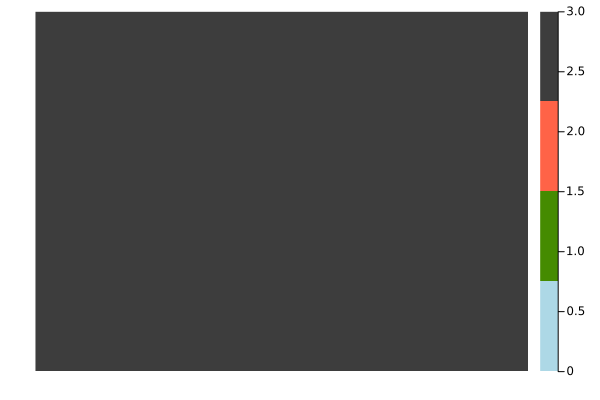

In [19]:
wind_speed = 0
w_angle = 0
gif(make_gif(forest, wind_speed, w_angle, elevation_matrix, vegetation_density), "pakiety projekt/wildfire.gif", fps = 1)

### 2 - Pole spalonego lasu w zależności od prędkości wiatru
- średnia gęstość roślinności
- teren płaski 
- prędkośc wiatru - 10, kierunek wiatru - 270

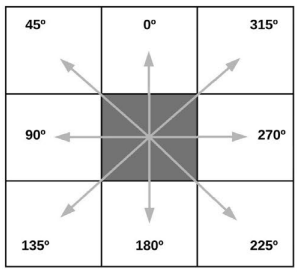

In [9]:
function calculate_p_wind(central_cell, neighbouring_cell, speed, wind_angle)
    c₁ = 0.045
    c₂ = 0.131
    i, j = central_cell
    k, l = neighbouring_cell
    if k == i-1
        if l == j-1
            fire_angle = 45
        elseif l == j
            fire_angle = 0
        else
            fire_angle = 315
        end
    elseif k == i
        if l == j-1
            fire_angle = 90
        else
            fire_angle = 270
        end
    else
        if l == j-1
            fire_angle = 135
        elseif l == j
            fire_angle = 180
        else
            fire_angle = 225
        end
    end
    Θ = deg2rad(wind_angle - fire_angle)
    return exp(c₁*speed)*exp(speed*c₂*(cos(Θ) - 1))
end

calculate_p_wind (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = C:\Users\mlubn\pakiety projekt\wildfire.gif
└ @ Plots C:\Users\mlubn\.julia\packages\Plots\cPJQu\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\mlubn\\pakiety projekt\\wildfire.gif")
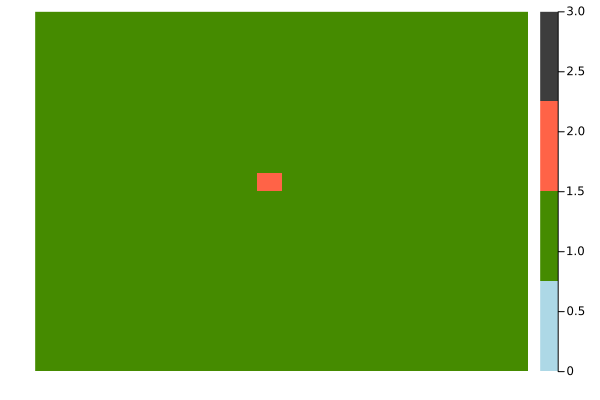

In [39]:
forest_size = 20
wind_speed = 15
wind_angle = 270
forest = [i == 1 || j == 1 || i == forest_size + 2 || j == forest_size + 2 ?
    0 : 1 for i in 1 : forest_size + 2, j in 1 : forest_size + 2]
forest[div(forest_size, 2) + 1, div(forest_size, 2) + 1] = 2;
vegetation_density = zeros(forest_size + 2, forest_size + 2)
elevation_matrix = zeros(forest_size + 2, forest_size + 2)
gif(make_gif(forest, wind_speed, wind_angle, elevation_matrix, vegetation_density), "pakiety projekt/wildfire.gif", fps = 1)

In [40]:
speed_array = 0: 0.5: 30
wind_angle = 270
s = 20
burnt_area_mean = zeros(length(speed_array))
for (j, wind_speed) in enumerate(speed_array)
    area_array = zeros(100)
    for i in 1: 100
        forest = [i == 1 || j == 1 || i == forest_size + 2 || j == forest_size + 2 ?
            0 : 1 for i in 1 : forest_size + 2, j in 1 : forest_size + 2]
        forest[div(forest_size + 2, 2), div(forest_size + 2, 2)] = 2
        forest = burn_forest(forest, wind_speed, wind_angle, elevation_matrix, vegetation_density)[1]
        burnt_area_percentage = count(i -> (i == 3), forest) / forest_size^2 * 100
        area_array[i] = burnt_area_percentage
    end
    burnt_area_mean[j] = mean(area_array)
end

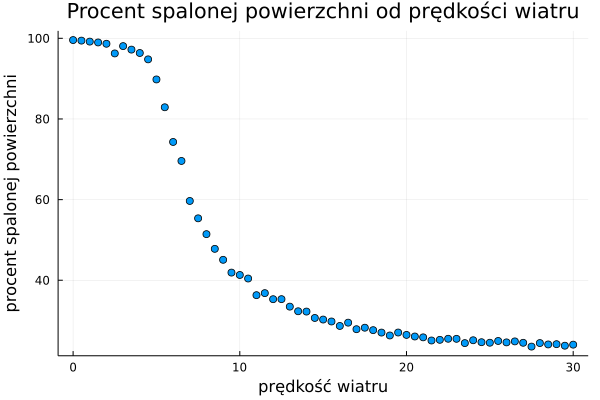

In [27]:
scatter(speed_array, burnt_area_mean, label = "", xlabel = "prędkość wiatru", ylabel = "procent spalonej powierzchni", title = "Procent spalonej powierzchni od prędkości wiatru")

### 3 - Prędkośc wypalania lasu w zależności od rzeźby terenu
- średnia gęstość roślinności
- prędkośc wiatru - 0
- zmieniająca się różnica wysokości

In [13]:
function calculate_p_ele(central_cell, neighbouring_cell, elevation_matrix)
    a = 0.078
    l = 20
    i, j = central_cell
    k, l = neighbouring_cell
    if i == k || j == l
        return exp(a * atan((elevation_matrix[k, l] - elevation_matrix[i, j])/l))
    else
        return exp(a * atan((elevation_matrix[k, l] - elevation_matrix[i, j])/(l * sqrt(2))))
    end
end

calculate_p_ele (generic function with 1 method)

In [14]:
forest_size = 20
wind_speed = 0
wind_angle = 0
vegetation_density = zeros(forest_size + 2, 2 * forest_size + 2)
lowest_point = 0
highest_points = 10 : 10 : 400;

In [15]:
burning_time_mean = zeros(length(highest_points))
for (j, highest_point) in enumerate(highest_points)
    elevations = LinRange(lowest_point, highest_point, 2*forest_size)
    elevation_matrix = [i == 1 || j == 1 || i == forest_size + 2 || j == 2*forest_size + 2 ?
        0 : elevations[i-1] for i in 1 : forest_size + 2, j in 1 : 2*forest_size + 2]
    time_array = zeros(200)
    for i in 1: 200
        forest = [i == 1 || j == 1 || i == forest_size + 2 || j == forest_size + 2 ?
            0 : 1 for i in 1 : forest_size + 2, j in 1 : forest_size + 2]
        forest[2, 2:forest_size] .= 2
        time = burn_forest(forest, wind_speed, wind_angle, elevation_matrix, vegetation_density)[2]
        time_array[i] = time
    end
    burning_time_mean[j] = mean(time_array)
end

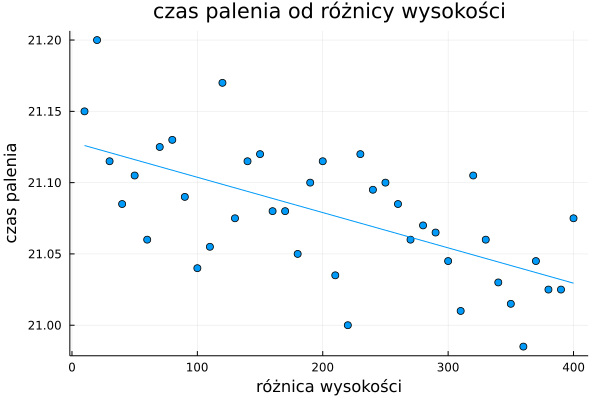

In [28]:
scatter(highest_points, burning_time_mean, label = "", xlabel = "różnica wysokości", ylabel = "czas palenia", smooth = :true, title = "czas palenia od różnicy wysokości")

### 4 - Gęstość roślinności
- zmieniająca się gęstość roślinności
- prędkośc wiatru - 0
- teren płaski

In [17]:
densities = [-0.4, 0, 0.3]
forest_size = 40
wind_speed = 0
wind_angle = 0
elevation_matrix = zeros(forest_size + 2, forest_size + 2)
for density in densities
    percentages = zeros(100)
    times = zeros(100)
    density_matrix = [density for i in 1: forest_size + 2, j in 1: forest_size + 2]
    for i in 1: 100
        forest = [i == 1 || j == 1 || i == s + 2 || j == forest_size + 2 ?
            0 : 1 for i in 1 : forest_size + 2, j in 1 : forest_size + 2]
        forest[2, 2] = 2
        forest, steps = burn_forest(forest, wind_speed, wind_angle, elevation_matrix, density_matrix)
        percentage = count(i -> (i == 3), forest) / forest_size^2 * 100
        percentages[i] = percentage
        times[i] = steps
    end
    display("dla gęstości roślinności " * string(density) * " średni czas wypalania lasu " * string(mean(times)) * " kroki, średni procent spalonej powierzchni " * string(mean(percentages)))
end

"dla gęstości roślinności -0.4 średni czas wypalania lasu 29.79 kroki, średni procent spalonej powierzchni 24.528125"

"dla gęstości roślinności 0.0 średni czas wypalania lasu 36.72 kroki, średni procent spalonej powierzchni 43.885"

"dla gęstości roślinności 0.3 średni czas wypalania lasu 39.63 kroki, średni procent spalonej powierzchni 48.99375"

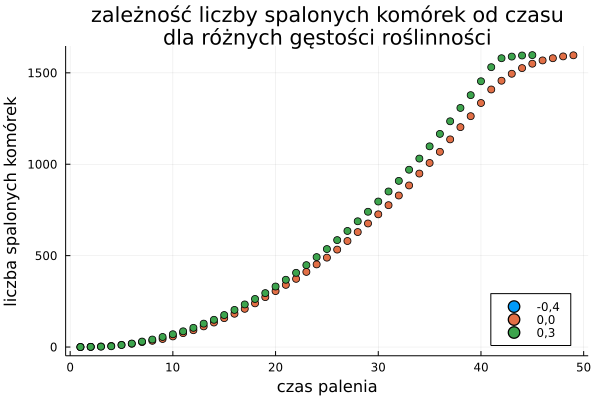

In [49]:
densities =[-0.4, 0.0, 0.3]
forest_size = 40
wind_speed = 0
wind_angle = 0
burnt_cells_combined=[]
time_combined=[]
elevation_matrix = zeros(forest_size + 2, forest_size + 2)
for density in densities
    density_matrix = [density for i in 1: forest_size + 2, j in 1: forest_size + 2]
    forest = [i == 1 || j == 1 || i == forest_size + 2 || j == forest_size + 2 ?
        0 : 1 for i in 1 : forest_size + 2, j in 1 : forest_size + 2]
    forest[2, 2] = 2
    forest, steps, burnt_cells_list = burn_forest(forest, wind_speed, wind_angle, elevation_matrix, density_matrix)
    time=Array(1:steps)
    push!(burnt_cells_combined,burnt_cells_list)
    push!(time_combined,time)
end


s = scatter(time_combined[1], burnt_cells_combined[1], label="-0,4")
scatter!(s, time_combined[2], burnt_cells_combined[2], label="0,0")
scatter!(s, time_combined[3], burnt_cells_combined[3], label="0,3", legend=:bottomright, xlabel = "czas palenia", ylabel = "liczba spalonych komórek", title = "zależność liczby spalonych komórek od czasu\ndla różnych gęstości roślinności")